In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
dataset = pd.read_csv("/content/traffic.csv")
dataset.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [ ]:
dataset["DateTime"]= pd.to_datetime(dataset["DateTime"])
dataset = dataset.drop(["ID"], axis=1) #dropping IDs column
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

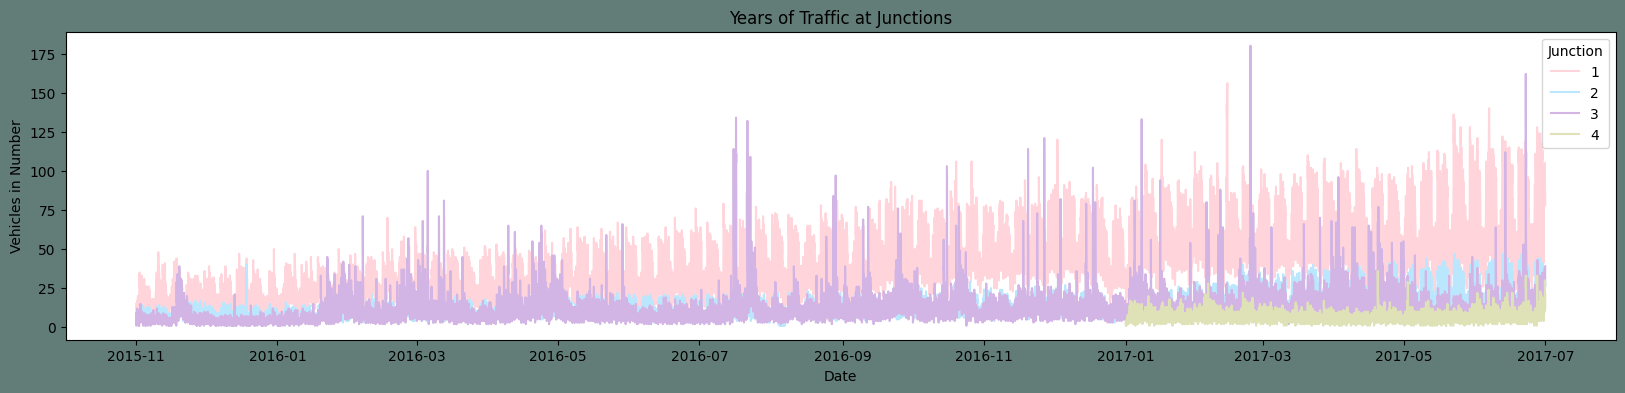

In [ ]:
# dataframe to be used for EDA
dataframe=dataset.copy()

# Let's plot the Timeseries
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=dataframe['DateTime'],y="Vehicles",data=dataframe, hue="Junction", palette=colors)
Time_series.set_title("Years of Traffic at Junctions")
Time_series.set_ylabel("Vehicles in Number")
Time_series.set_xlabel("Date")

In [ ]:
# Exploring more features
dataframe["Year"]= dataframe['DateTime'].dt.year
dataframe["Month"]= dataframe['DateTime'].dt.month
dataframe["Date_no"]= dataframe['DateTime'].dt.day
dataframe["Hour"]= dataframe['DateTime'].dt.hour
dataframe["Day"]= dataframe.DateTime.dt.strftime("%A")
dataframe.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


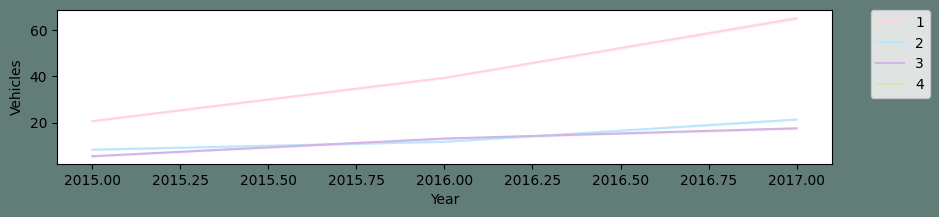

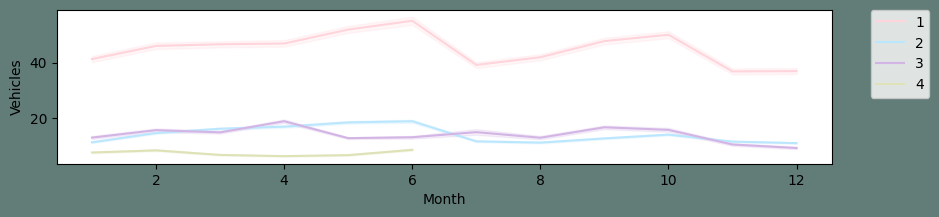

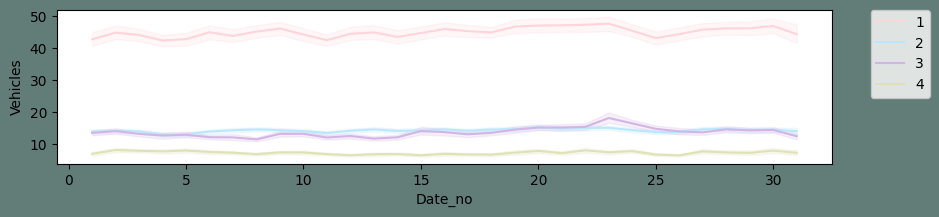

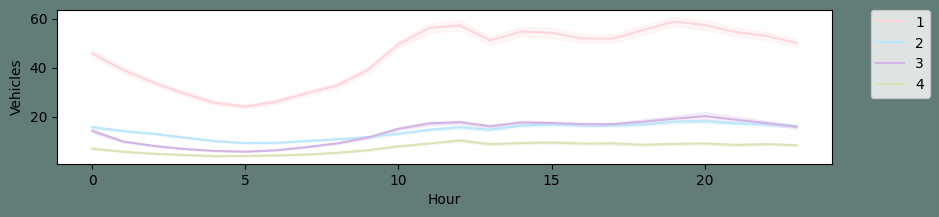

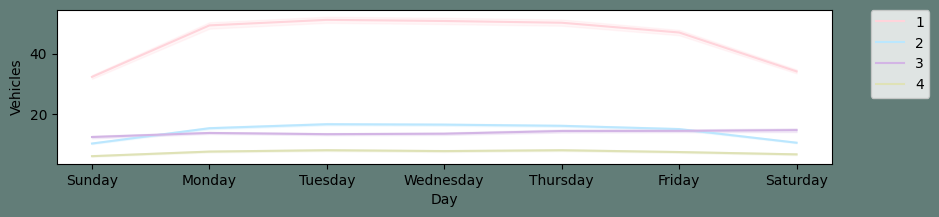

In [ ]:
# Let's plot the Timeseries
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor="#627D78")
    ax=sns.lineplot(x=dataframe[i],y="Vehicles",data=dataframe, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
# Pivoting dataset from junction
dataframe_junction = dataset.pivot(columns="Junction", index="DateTime")
dataframe_junction.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

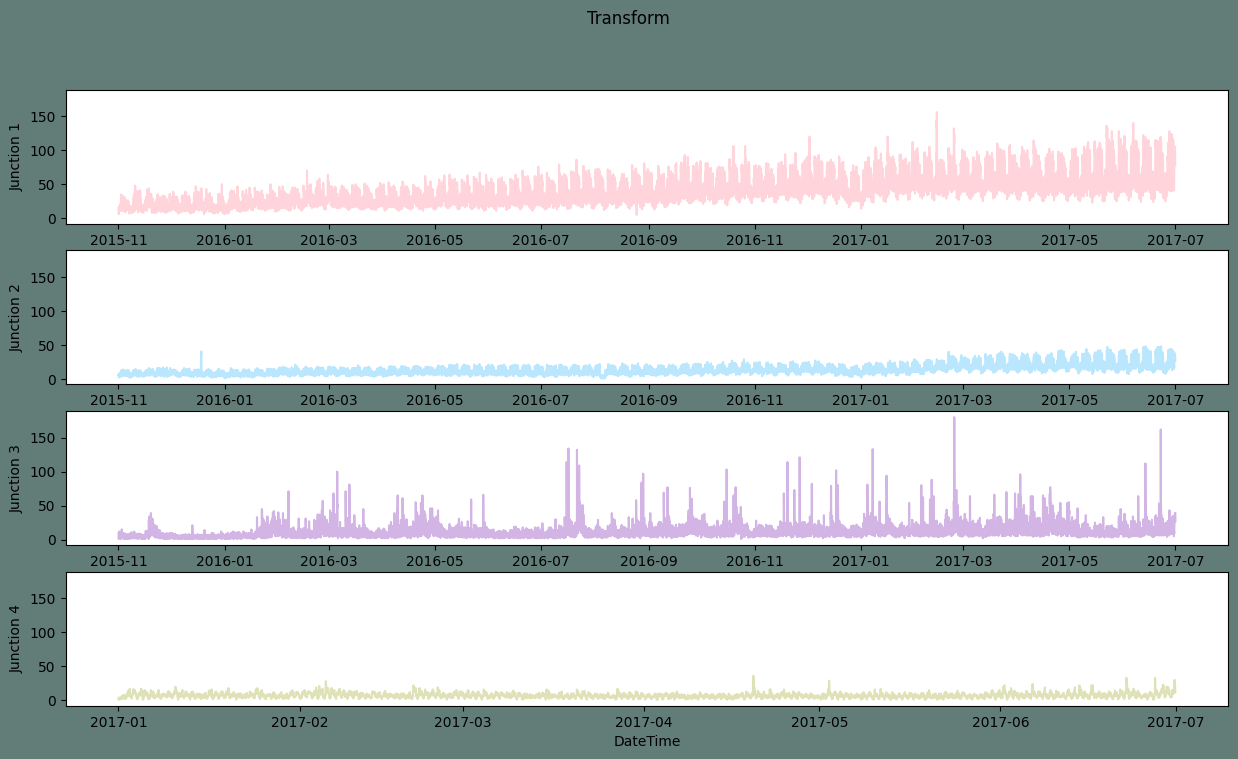

In [ ]:
# Creating new dataframes
dataframe_1 = dataframe_junction[[('Vehicles', 1)]]
dataframe_2 = dataframe_junction[[('Vehicles', 2)]]
dataframe_3 = dataframe_junction[[('Vehicles', 3)]]
dataframe_4 = dataframe_junction[[('Vehicles', 4)]]
dataframe_4 = dataframe_4.dropna() #For only a few months, Junction 4 has only had minimal data.

# As DFS's data frame contains many indices, its index is lowering level one.
list_dfs = [dataframe_1, dataframe_2, dataframe_3, dataframe_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)

# Creates comparison dataframe charts using this function
def Sub_Plots4(dataframe_1, dataframe_2,dataframe_3,dataframe_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=dataframe_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=dataframe_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=dataframe_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=dataframe_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")


# It is displayed to test for stationarity.
Sub_Plots4(dataframe_1.Vehicles, dataframe_2.Vehicles,dataframe_3.Vehicles,dataframe_4.Vehicles,"Transform")

In [ ]:
# Normalize Function
def Normalize(dataframe,column):
    average = dataframe[column].mean()
    stdev = dataframe[column].std()
    df_normalized = (dataframe[column] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(dataframe,column, interval):
    diff = []
    for i in range(interval, len(dataframe)):
        value = dataframe[column][i] - dataframe[column][i - interval]
        diff.append(value)
    return diff

In [ ]:
# In order to make the series stationary, normalize and differ
dataframe_N1, avg_J1, std_J1 = Normalize(dataframe_1, "Vehicles")
Diff_1 = Difference(dataframe_N1, column="Vehicles", interval=(24*7)) #taking a week's difference
dataframe_N1 = dataframe_N1[24*7:]
dataframe_N1.columns = ["Norm"]
dataframe_N1["Diff"]= Diff_1

dataframe_N2, avg_J2, std_J2 = Normalize(dataframe_2, "Vehicles")
Diff_2 = Difference(dataframe_N2, column="Vehicles", interval=(24)) #taking a day's difference
dataframe_N2 = dataframe_N2[24:]
dataframe_N2.columns = ["Norm"]
dataframe_N2["Diff"]= Diff_2

dataframe_N3, avg_J3, std_J3 = Normalize(dataframe_3, "Vehicles")
Diff_3 = Difference(dataframe_N3, column="Vehicles", interval=1) #taking an hour's difference
dataframe_N3 = dataframe_N3[1:]
dataframe_N3.columns = ["Norm"]
dataframe_N3["Diff"]= Diff_3

dataframe_N4, avg_J4, std_J4 = Normalize(dataframe_4, "Vehicles")
Diff_4 = Difference(dataframe_N4, column="Vehicles", interval=1) #taking an hour's difference
dataframe_N4 = dataframe_N4[1:]
dataframe_N4.columns = ["Norm"]
dataframe_N4["Diff"]= Diff_4

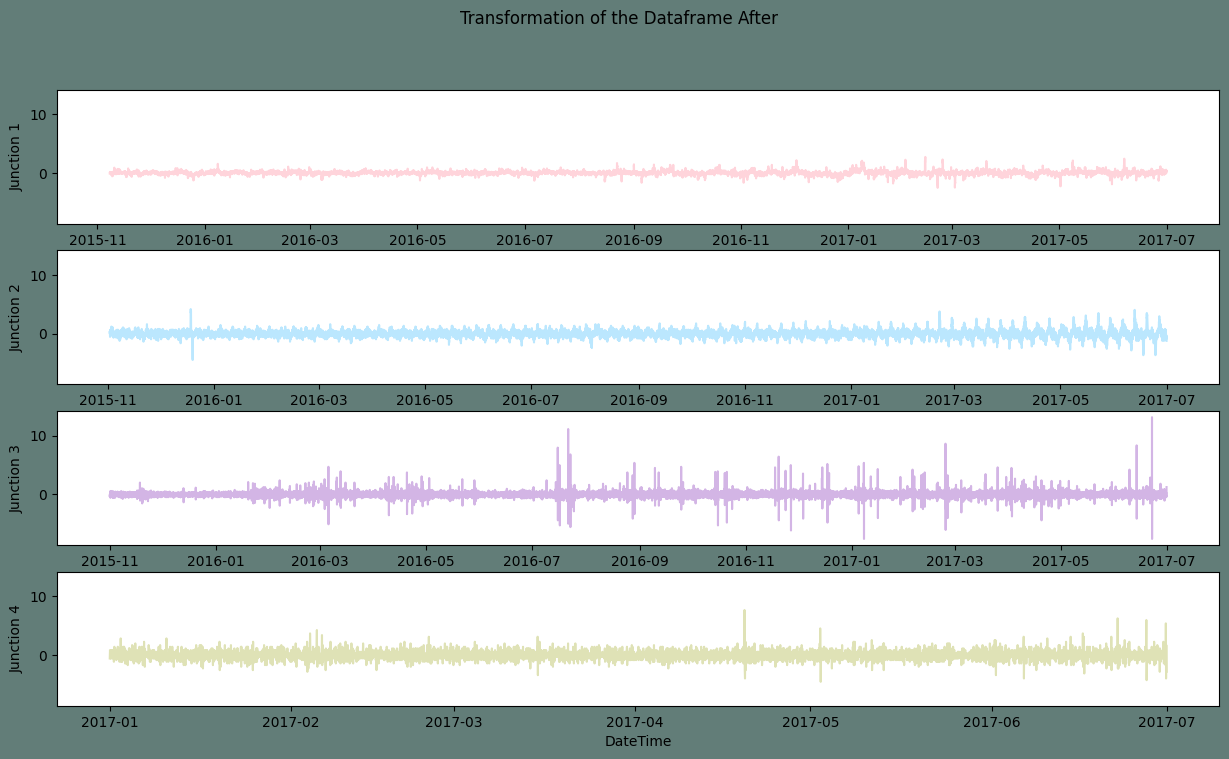

In [ ]:
Sub_Plots4(dataframe_N1.Diff, dataframe_N2.Diff,dataframe_N3.Diff,dataframe_N4.Diff,"Transformation of the Dataframe After")

In [ ]:
# Stationary time series check Improved Dickey-Fuller test
def Stationary_check(dataframe):
    check = adfuller(dataframe.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary")


# examining the series' stationary state

List_df_ND = [ dataframe_N1["Diff"], dataframe_N2["Diff"], dataframe_N3["Diff"], dataframe_N4["Diff"]]
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415337
p-value: 4.79853987639816e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940065
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832316
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.979092563052276
p-value: 2.778787532595421e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [ ]:
# Several NA values were produced as a result of differencing using a week's worth of data.
dataframe_J1 = dataframe_N1["Diff"].dropna()
dataframe_J1 = dataframe_J1.to_frame()

dataframe_J2 = dataframe_N2["Diff"].dropna()
dataframe_J2 = dataframe_J2.to_frame()

dataframe_J3 = dataframe_N3["Diff"].dropna()
dataframe_J3 = dataframe_J3.to_frame()

dataframe_J4 = dataframe_N4["Diff"].dropna()
dataframe_J4 = dataframe_J4.to_frame()

# Splitting the dataset
def Split_data(dataframe):
    training_size = int(len(dataframe)*0.90)
    data_len = len(dataframe)
    train, test = dataframe[0:training_size],dataframe[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
# Splitting the training and test datasets
Junction1_train, Junction1_test = Split_data(dataframe_J1)
Junction2_train, Junction2_test = Split_data(dataframe_J2)
Junction3_train, Junction3_test = Split_data(dataframe_J3)
Junction4_train, Junction4_test = Split_data(dataframe_J4)

# Target and Feature
def target_and_feature(dataframe):
    end_len = len(dataframe)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(dataframe[i - steps:i, 0])
        y.append(dataframe[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

# fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

# Assigning features and target
X_train_Junction1, y_train_Junction1 = target_and_feature(Junction1_train)
X_test_Junction1, y_test_Junction1 = target_and_feature(Junction1_test)
X_train_Junction1, X_test_Junction1 = FeatureFixShape(X_train_Junction1, X_test_Junction1)

X_train_Junction2, y_train_Junction2 = target_and_feature(Junction2_train)
X_test_Junction2, y_test_Junction2 = target_and_feature(Junction2_test)
X_train_Junction2, X_test_Junction2 = FeatureFixShape(X_train_Junction2, X_test_Junction2)

X_train_Junction3, y_train_Junction3 = target_and_feature(Junction3_train)
X_test_Junction3, y_test_Junction3 = target_and_feature(Junction3_test)
X_train_Junction3, X_test_Junction3 = FeatureFixShape(X_train_Junction3, X_test_Junction3)

X_train_Junction4, y_train_Junction4 = target_and_feature(Junction4_train)
x_test_Junction4, y_test_Junction4 = target_and_feature(Junction4_test)
X_train_Junction4, x_test_Junction4 = FeatureFixShape(X_train_Junction4, x_test_Junction4)

In [ ]:
X_train_Junction1.shape

(12949, 32, 1)

In [ ]:

#GRU Model for the prediction
def GRU_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
    #callback delta 0.01 may interrupt the learning.

    #The GRU model
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU


#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#686D76")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

In [ ]:
print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ1_GRU = GRU_model(X_train_Junction1,y_train_Junction1,X_test_Junction1, y_test_Junction1)
print("-" * 70)


########------GRU Model------########
Epoch 1/50
108/108 [==============================] - 51s 372ms/step - loss: 0.0750 - val_loss: 0.0921
Epoch 2/50
108/108 [==============================] - 35s 328ms/step - loss: 0.0649 - val_loss: 0.0875
Epoch 3/50
108/108 [==============================] - 36s 337ms/step - loss: 0.0635 - val_loss: 0.0843
Epoch 4/50
108/108 [==============================] - 35s 329ms/step - loss: 0.0620 - val_loss: 0.0811
Epoch 5/50
108/108 [==============================] - 50s 460ms/step - loss: 0.0604 - val_loss: 0.0802
Epoch 6/50
108/108 [==============================] - 37s 339ms/step - loss: 0.0591 - val_loss: 0.0764
Epoch 7/50
108/108 [==============================] - 35s 328ms/step - loss: 0.0586 - val_loss: 0.0757
Epoch 8/50
108/108 [==============================] - 37s 343ms/step - loss: 0.0570 - val_loss: 0.0740
Epoch 9/50
108/108 [==============================] - 37s 341ms/step - loss: 0.0559 - val_loss: 0.0727
Epoch 10/50
108/108 [==============

########------GRU Model------########
The root mean squared error is 0.24761670834746094.


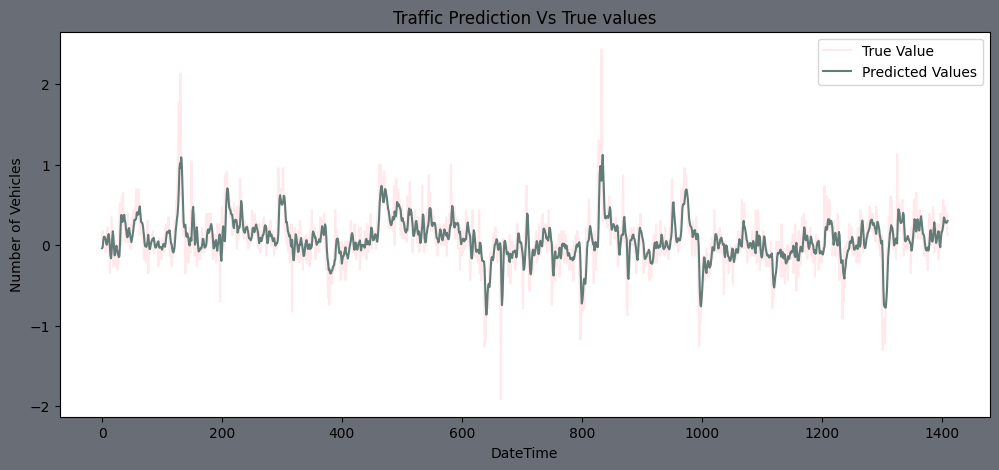

In [ ]:
# Results for J1 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J1_GRU = RMSE_Value(y_test_Junction1, PredJ1_GRU)
PredictionsPlot(y_test_Junction1, PredJ1_GRU, 0)

In [ ]:
print("\033[1;31;2m########------GRU Model for junction2------########\033[0m")
PredJ2_GRU = GRU_model(X_train_Junction2,y_train_Junction2,X_test_Junction2, y_test_Junction2)
print("-" * 70)

########------GRU Model for junction2------########
Epoch 1/50
109/109 [==============================] - 66s 370ms/step - loss: 0.2356 - val_loss: 0.4518
Epoch 2/50
109/109 [==============================] - 36s 330ms/step - loss: 0.2042 - val_loss: 0.3917
Epoch 3/50
109/109 [==============================] - 39s 359ms/step - loss: 0.1973 - val_loss: 0.3704
Epoch 4/50
109/109 [==============================] - 37s 341ms/step - loss: 0.1938 - val_loss: 0.3586
Epoch 5/50
109/109 [==============================] - 37s 335ms/step - loss: 0.1931 - val_loss: 0.3427
Epoch 6/50
109/109 [==============================] - 37s 336ms/step - loss: 0.1920 - val_loss: 0.3460
Epoch 7/50
109/109 [==============================] - 35s 324ms/step - loss: 0.1912 - val_loss: 0.3450
Epoch 8/50
109/109 [==============================] - 37s 339ms/step - loss: 0.1906 - val_loss: 0.3342
Epoch 9/50
109/109 [==============================] - 39s 355ms/step - loss: 0.1883 - val_loss: 0.3350
Epoch 10/50
109/109 [

########------GRU Model------########
The root mean squared error is 0.5503864502942962.


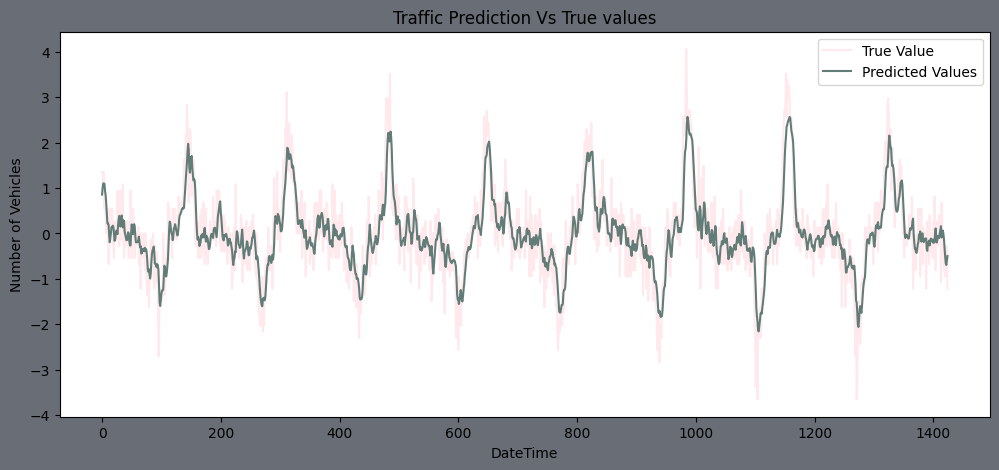

In [ ]:
# Results for J2 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J2_GRU = RMSE_Value(y_test_Junction2, PredJ2_GRU)
PredictionsPlot(y_test_Junction2, PredJ2_GRU, 0)

In [ ]:
print("\033[1;31;2m########------GRU Model for junction3------########\033[0m")
PredJ3_GRU = GRU_model(X_train_Junction3,y_train_Junction3,X_test_Junction3, y_test_Junction3)
print("-" * 70)

########------GRU Model for junction3------########
Epoch 1/50
110/110 [==============================] - 48s 352ms/step - loss: 0.3041 - val_loss: 0.4010
Epoch 2/50
110/110 [==============================] - 37s 338ms/step - loss: 0.2977 - val_loss: 0.3986
Epoch 3/50
110/110 [==============================] - 37s 336ms/step - loss: 0.2929 - val_loss: 0.4061
Epoch 4/50
110/110 [==============================] - 37s 339ms/step - loss: 0.2900 - val_loss: 0.4024
Epoch 5/50
110/110 [==============================] - 35s 322ms/step - loss: 0.2904 - val_loss: 0.3935
Epoch 6/50
110/110 [==============================] - 37s 339ms/step - loss: 0.2889 - val_loss: 0.3963
Epoch 7/50
110/110 [==============================] - 37s 339ms/step - loss: 0.2881 - val_loss: 0.3912
Epoch 8/50
110/110 [==============================] - 37s 336ms/step - loss: 0.2896 - val_loss: 0.3933
Epoch 9/50
110/110 [==============================] - 37s 333ms/step - loss: 0.2878 - val_loss: 0.3953
Epoch 10/50
110/110 [

########------GRU Model------########
The root mean squared error is 0.6081698451707989.


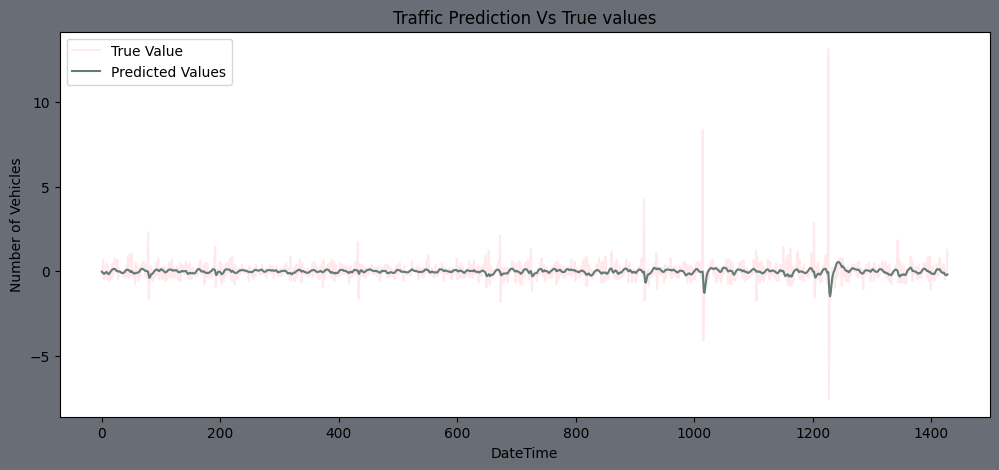

In [ ]:
# Results for J3 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J3_GRU = RMSE_Value(y_test_Junction3, PredJ3_GRU)
PredictionsPlot(y_test_Junction3, PredJ3_GRU, 0)

In [ ]:
print("\033[1;31;2m########------GRU Model for junction4------########\033[0m")
PredJ4_GRU = GRU_model(X_train_Junction4,y_train_Junction4,x_test_Junction4, y_test_Junction4)
print("-" * 70)

########------GRU Model for junction4------########
Epoch 1/50
33/33 [==============================] - 29s 401ms/step - loss: 0.6889 - val_loss: 1.2398
Epoch 2/50
33/33 [==============================] - 11s 346ms/step - loss: 0.6870 - val_loss: 1.2337
Epoch 3/50
33/33 [==============================] - 11s 346ms/step - loss: 0.6864 - val_loss: 1.2297
Epoch 4/50
33/33 [==============================] - 11s 345ms/step - loss: 0.6834 - val_loss: 1.2279
Epoch 5/50
33/33 [==============================] - 10s 290ms/step - loss: 0.6905 - val_loss: 1.2543
Epoch 6/50
33/33 [==============================] - 13s 371ms/step - loss: 0.6823 - val_loss: 1.2251
Epoch 7/50
33/33 [==============================] - 11s 344ms/step - loss: 0.6801 - val_loss: 1.2221
Epoch 8/50
33/33 [==============================] - 12s 354ms/step - loss: 0.6790 - val_loss: 1.2202
Epoch 9/50
33/33 [==============================] - 12s 351ms/step - loss: 0.6781 - val_loss: 1.2211
Epoch 10/50
33/33 [====================

########------GRU Model------########
The root mean squared error is 1.0046228027289497.


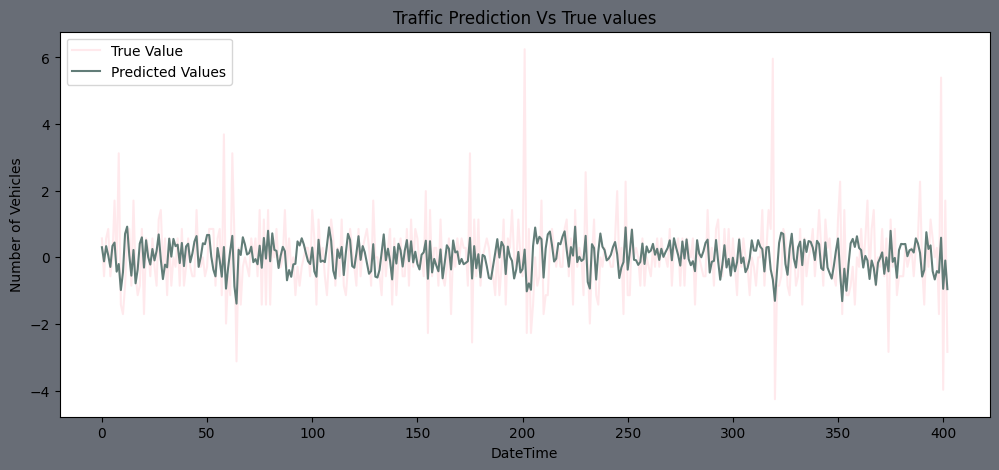

In [ ]:
# Results for J4 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J4_GRU = RMSE_Value(y_test_Junction4, PredJ4_GRU)
PredictionsPlot(y_test_Junction4, PredJ4_GRU, 0)

In [ ]:
# Set the data in lists to the initial error values of the four junctions.
Junctions = ["Junction1", "Junction2", "Junction3", "Junction4"]
RMSE = [RMSE_J1_GRU, RMSE_J2_GRU, RMSE_J3_GRU, RMSE_J4_GRU]
list_of_tuples = list(zip(Junctions, RMSE))
# Creates pandas DataFrame.
Results = pd.DataFrame(list_of_tuples, columns=["Junction", "RMSE"])
Results.style.background_gradient(cmap="Pastel1")

,Junction,RMSE
0,Junction1,0.247617
1,Junction2,0.550386
2,Junction3,0.608170
3,Junction4,1.004623
